In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

In [2]:
dataset = pd.read_csv(filepath_or_buffer='../all_data.csv', index_col=0)
FEATURES_INDEX = np.arange(2)
LABELS_INDEX = 2
BATCH_SIZE = int(0.6*len(dataset))
LOSS_THRESHOLD = 1e-6
dataset.head()
dataset=np.array(dataset)

In [3]:
learn_dataset = dataset[0: int(0.6*len(dataset))]
valid_dataset = dataset[int(0.6*len(dataset)): int(0.9*len(dataset))]
test_dataset = dataset[int(0.9*len(dataset)): len(dataset)]
len(dataset)

7775

In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('adagrad/net_params.pkl'))

In [8]:
#Инициализация весов
STD = [(2/(10+1+1))**(1/2), (2/(10+10+1))**(1/2), (32/(5+10+1))**(1/2), (32/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([ 0.8056, -0.3722, -0.4594, -0.7103,  0.1163,  0.4636,  0.3622,
         0.8127,  0.2758, -0.4229])


In [9]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.8056, -0.3722, -0.4594, -0.7103,  0.1163,  0.4636,  0.3622,
         0.8127,  0.2758, -0.4229])

In [10]:
criterion = nn.MSELoss(size_average=True)
lr = 0.001

In [11]:
sss = torch.zeros((5,5))
asd = [2,2]
sss[2,2]

tensor(0.)

In [12]:
def get_lr(state, lr):
    tmp = state['sum']
    tmp = lr*torch.rsqrt(tmp.add_(1e-10))
    return tmp

In [24]:
%%time
optimizer = optim.Adagrad(net.parameters(), lr=lr)
state = optimizer.state

tmp_null_weigth = list(null_weigth)
net.apply(init_weigths)

learn_epoch_loss = []
valid_epoch_loss = []
test_epoch_loss = []
epoch_list = []

lr_l1 = []
lr_l2 = []
lr_l3 = []
lr_l4 = []

lr_mean = []
lr_min = []
lr_max = []

for epoch in range(5*10**3):
    loss_acc = []
    min_acc = 1000
    max_acc = -1000
    mean_acc = 0
    
    for learn_data in learn_dataloader:
        optimizer.zero_grad()
        features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
        features.requres_grad = True
        labels.requres_grad = True
        outputs = net(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acc.append(float(loss.data))
    learn_epoch_loss.append(np.mean(loss_acc))

    #критерий останова
    if (epoch > 10) and (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break

    if epoch % 10 == 0:
        epoch_list.append(epoch)
        for valid_data in valid_dataloader:
            features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            valid_epoch_loss.append(float(loss.data))

        for test_data in valid_dataloader:
            features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            test_epoch_loss.append(float(loss.data))
            
        state_values = list(state.values())
        for k in range(len(state_values)):
            g_matrix = get_lr(state_values[k], lr)
            mean_acc += float(torch.mean(g_matrix))
            max_acc = max(max_acc, float(torch.max(g_matrix)))
            min_acc = min(min_acc, float(torch.min(g_matrix)))
        lr_max.append(max_acc)
        lr_mean.append(mean_acc/len(state_values))
        lr_min.append(min_acc)
        
        g_matrix = get_lr(state_values[0], lr)
        lr_l1.append(float(g_matrix[0, 0]))
        
        g_matrix = get_lr(state_values[2], lr)
        lr_l2.append(float(g_matrix[0, 0]))
        
        g_matrix = get_lr(state_values[4], lr)
        lr_l3.append(float(g_matrix[0, 0]))
        
        g_matrix = get_lr(state_values[6], lr)
        lr_l4.append(float(g_matrix[0, 0]))
        
        
        

CPU times: user 4min 10s, sys: 3.42 s, total: 4min 13s
Wall time: 3min 23s


In [25]:
for i in state:
    print(i.shape)

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])


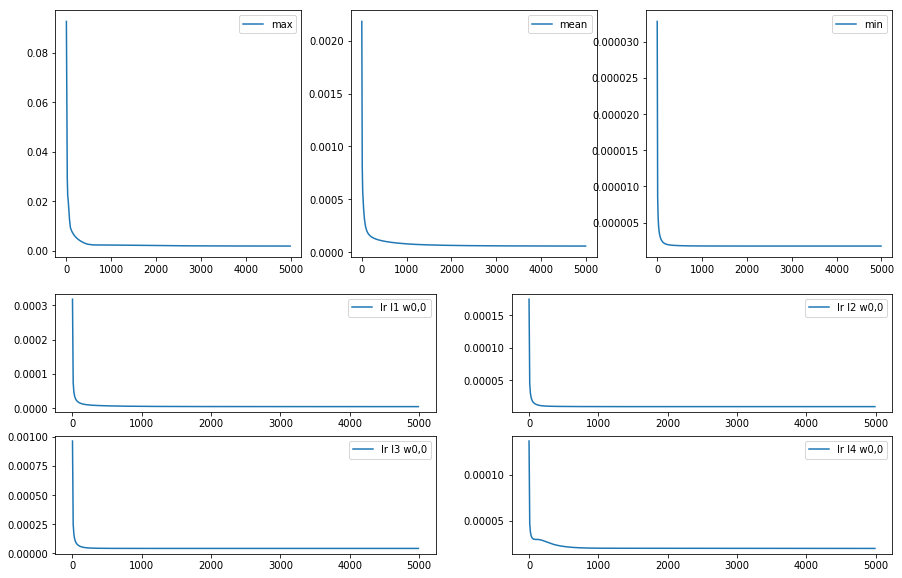

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(4, 2, 5)
plt.plot(epoch_list, lr_l1, label='lr l1 w0,0')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(epoch_list, lr_l2, label='lr l2 w0,0')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(epoch_list, lr_l3, label='lr l3 w0,0')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(epoch_list, lr_l4, label='lr l4 w0,0')
plt.legend()

plt.subplot(2, 3, 1)
plt.plot(epoch_list, lr_max, label='max')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epoch_list, lr_mean, label='mean')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epoch_list, lr_min, label='min')
plt.legend()

plt.savefig('adagrad/lrs.png', bbox_inches='tight')

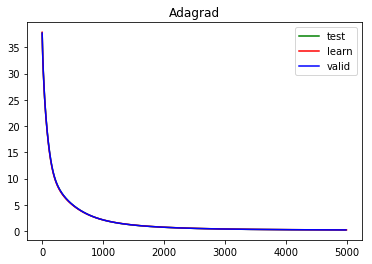

In [30]:
plt.plot(learn_epoch_loss, c='r', label='learn')
plt.plot(epoch_list, valid_epoch_loss, c='b', label='valid')
plt.plot(epoch_list, test_epoch_loss, c='g', label='test')
plt.legend()

plt.title('Adagrad')
plt.legend()
plt.savefig('adagrad/test_loss.png', bbox_inches='tight')

In [28]:
print(lr_mean[-1])
print(lr_min[-1])
print(lr_max[-1])

5.664053179543771e-05
1.7554243640915956e-06
0.0018250070279464126


In [29]:
print(learn_epoch_loss[-1])
print(test_epoch_loss[-1])

0.21771776676177979
0.2143820971250534
